In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import json

Using TensorFlow backend.


In [2]:
f = open('data.json', encoding="utf8")
data = json.load(f)
len(data)

3737

In [3]:
for d in data:
    d['text'] = d['title'] + d['text']

In [4]:
df = pd.DataFrame(data)
del df['website']
del df['title']
df.head()

,labels,text
0,[Coronavirus],Coronavirus: Royal Mail's Derry staff in stand...
1,"[US election 2020, Donald Trump]",US election 2020 polls: Who is ahead - Trump o...
2,"[Personal finance, Companies, Retailing, Coron...",Visa and Mastercard accused of charging 'exces...
3,[United States],Jeff Bridges: Oscar-winning US actor reveals h...
4,"[Boris Johnson, Brexit]",Brexit: Have EU-UK trade talks reached a dead ...


In [5]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['labels'])
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [6]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [7]:
X = []
sentences = list(df["text"])
for sen in sentences:
    X.append(preprocess_text(sen))

In [8]:
print("Before:\n" + df["text"][0])
print()
print("After:\n" + X[0])

Before:
Coronavirus: Royal Mail's Derry staff in standoff over deep cleanRoyal Mail staff in Londonderry have refused to enter the city's sorting office until a deep clean of the premises is carried out. More than 40 staff - a third of its 120-strong workforce - are off work because of Covid-19, the Communication Workers' Union (CWU) said. The union said 17 staff at the office have tested positive, with 13 of those having been diagnosed since Friday. A further 25 members of staff are self-isolating, it added. The CWU's Charlie Kelly said it is a "scary time for staff". He said it is "highly unlikely" there will be a postal service in the city on Tuesday. "Staff want a commitment as to when it (the deep clean) is going to get done," he said.  "Until we get that commitment they say they are not going back into the building because they feel their health and safety is under threat." Staff and management are due to hold talks later on Tuesday morning. There have been 4,292 confirmed cases 

In [26]:
tags = {}
for t in mlb.classes_:
    tags[t] = 0
for l in df['labels']:
    for t in l:
        tags[t] += 1
print(tags)

for t in tags:
    tags[t] = (int)(tags[t]*0.2)
tags

{'Boris Johnson': 170, 'Brexit': 277, 'Cardiff': 117, 'China': 296, 'Companies': 313, 'Coronavirus': 1898, 'Donald Trump': 243, 'India': 132, 'Manchester': 139, 'NHS': 228, 'Personal finance': 153, 'Police': 247, 'Retailing': 129, 'Self-isolation': 140, 'Social distancing': 102, 'Social media': 102, 'UK economy': 233, 'US election 2020': 100, 'United States': 333, 'Welsh government': 130}


{'Boris Johnson': 34,
 'Brexit': 55,
 'Cardiff': 23,
 'China': 59,
 'Companies': 62,
 'Coronavirus': 379,
 'Donald Trump': 48,
 'India': 26,
 'Manchester': 27,
 'NHS': 45,
 'Personal finance': 30,
 'Police': 49,
 'Retailing': 25,
 'Self-isolation': 28,
 'Social distancing': 20,
 'Social media': 20,
 'UK economy': 46,
 'US election 2020': 20,
 'United States': 66,
 'Welsh government': 26}

In [27]:
X_train = []
X_test = []
y_train = np.empty(shape=(0,len(mlb.classes_)),dtype=int) # bool?
y_test = np.empty(shape=(0,len(mlb.classes_)),dtype=int)

for x in range(len(X)):
    flag = False
    for t in df.iloc[x]['labels']:
        if(tags[t] > 0):
            flag = True
    if flag:
        for t in df.iloc[x]['labels']:
            tags[t] -= 1
        X_test.append(df.iloc[x]['text'])
        y_test = np.vstack([y_test, y[x]])
    else:
        X_train.append(df.iloc[x]['text'])
        y_train = np.vstack([y_train, y[x]])

In [28]:
print(f"Splitted to train {len(X_train)} and test {len(X_test)} ")

Splitted to train 3005 and test 732 


In [29]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

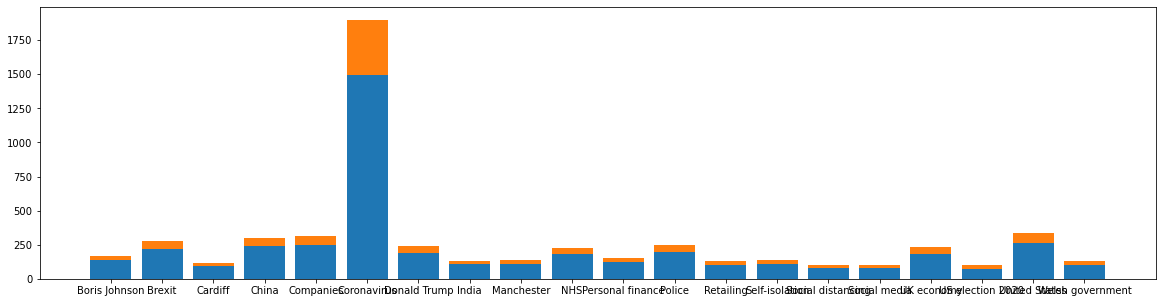

In [30]:
sum_y = y.sum(axis = 0)
sum_y_train = y_train.sum(axis = 0)
sum_y_test = y_test.sum(axis = 0)

xloc = np.arange(y.shape[1])
barWidth = 0.8

#display stacked bar chart
plt.figure(figsize=(20,5))
p1 = plt.bar(xloc, sum_y_train, width=barWidth)
p2 = plt.bar(xloc, sum_y_test, bottom=sum_y_train, width=barWidth)
plt.xticks(xloc, mlb.classes_)
# plt.savefig("train_test_split_ratio.png")
plt.show()

In [31]:
ratio = sum_y_test / sum_y * 100
np.sort(ratio)
# 30% is US election 2020

array([19.37984496, 19.42446043, 19.60784314, 19.6969697 , 19.73684211,
       19.85559567, 19.93243243, 20.24291498, 20.42042042, 20.44728435,
       20.51282051, 20.58823529, 20.58823529, 20.58823529, 21.23287671,
       22.14285714, 22.30769231, 22.63374486, 23.17596567, 30.        ])

In [14]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [15]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [16]:
number_of_classes = y.shape[1]
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=maxlen, weights=[embedding_matrix], trainable=False))
model.add(LSTM(128))
model.add(Dense(number_of_classes, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          4586500   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2580      
Total params: 4,706,328
Trainable params: 119,828
Non-trainable params: 4,586,500
_________________________________________________________________


In [17]:
epoch_num = 8
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=128, epochs=epoch_num, verbose=1, validation_split=0.2) # validation may not be good

Train on 2404 samples, validate on 601 samples
Epoch 1/8
2404/2404 [==============================] - 10s 4ms/step - loss: 0.3762 - acc: 0.8878 - val_loss: 0.2168 - val_acc: 0.9305
Epoch 2/8
2404/2404 [==============================] - 8s 3ms/step - loss: 0.2223 - acc: 0.9290 - val_loss: 0.2153 - val_acc: 0.9318
Epoch 3/8
2404/2404 [==============================] - 8s 3ms/step - loss: 0.2192 - acc: 0.9295 - val_loss: 0.2131 - val_acc: 0.9319
Epoch 4/8
2404/2404 [==============================] - 8s 3ms/step - loss: 0.2175 - acc: 0.9307 - val_loss: 0.2117 - val_acc: 0.9331
Epoch 5/8
2404/2404 [==============================] - 8s 3ms/step - loss: 0.2163 - acc: 0.9314 - val_loss: 0.2105 - val_acc: 0.9324
Epoch 6/8
2404/2404 [==============================] - 8s 3ms/step - loss: 0.2148 - acc: 0.9318 - val_loss: 0.2103 - val_acc: 0.9344
Epoch 7/8
2404/2404 [==============================] - 8s 3ms/step - loss: 0.2122 - acc: 0.9329 - val_loss: 0.2068 - val_acc: 0.9372
Epoch 8/8
2404/2404 [

In [18]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

732/732 [==============================] - 1s 1ms/step
Test Score: 0.22309359224116215
Test Accuracy: 0.9297130107879639


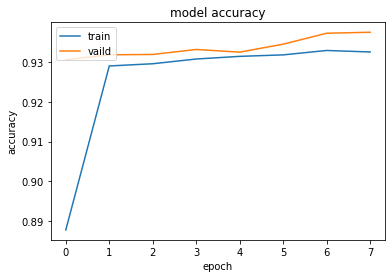

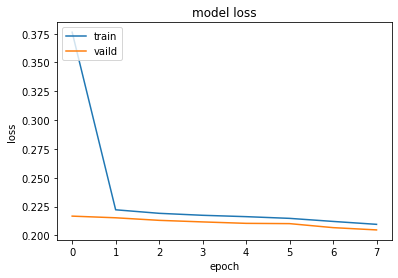

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','vaild'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','vaild'], loc='upper left')
plt.show()